In [10]:
# ================================
# 1. Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

# ================================
# 2. Load data
# ================================
data_path = "/content/processed_co2_dataset_with_datetime.csv"
df = pd.read_csv(data_path)

print("Loaded:", data_path)
print("Shape:", df.shape)
df.head()


Loaded: /content/processed_co2_dataset_with_datetime.csv
Shape: (500, 14)


,PM2.5,PM10,NOx,NO2,SO2,VOCs,CO,CO2,CH4,Temperature,Humidity,Wind_Direction,Location_Type,datetime
0,39.967142,57.926035,116.192213,55.230299,4.531693,75.317261,2.789606,427.674347,1.706105,31.085120,45.454749,276,Urban,1/1/2000 0:00
1,101.935672,150.774299,76.826826,79.051618,18.744780,145.083987,1.966569,529.739619,2.492663,33.711103,60.798212,134,Industrial,1/1/2000 1:00
2,70.996192,138.948796,158.731020,60.466604,14.892239,145.147338,2.626446,499.889443,2.431165,33.778698,54.875669,1,Industrial,1/1/2000 2:00
3,28.464728,63.643900,25.385343,15.333286,7.647429,130.022319,1.779360,388.283712,1.818563,31.565877,67.113319,251,Rural,1/1/2000 3:00
4,78.265276,113.977926,105.644340,59.202337,17.696806,181.713667,3.240533,464.739197,2.597225,32.229835,37.236519,326,Industrial,1/1/2000 4:00


In [11]:
# ================================
# 3. Infer datetime column
# ================================
datetime_cols = [
    col for col in df.columns
    if any(x in col.lower() for x in ["date", "time", "timestamp"])
]

if len(datetime_cols) == 0:
    raise ValueError("No datetime column detected. Please specify manually.")

dt_col = datetime_cols[0]
print("Using datetime column:", dt_col)

df[dt_col] = pd.to_datetime(df[dt_col])
df = df.sort_values(dt_col).set_index(dt_col)


Using datetime column: datetime


In [12]:
df = pd.read_csv("/content/processed_co2_dataset_with_datetime.csv")
print(df.columns)


Index(['PM2.5', 'PM10', 'NOx', 'NO2', 'SO2', 'VOCs', 'CO', 'CO2', 'CH4',
       'Temperature', 'Humidity', 'Wind_Direction', 'Location_Type',
       'datetime'],
      dtype='object')


In [13]:
# ================================
# 4. Select target variable
# ================================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Pick CO as default if exists
target = "CO" if "CO" in numeric_cols else numeric_cols[0]
print("Using target:", target)


Using target: CO


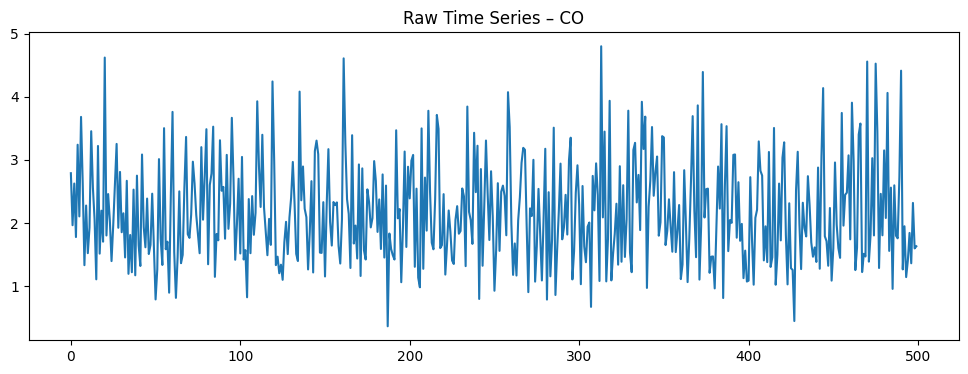

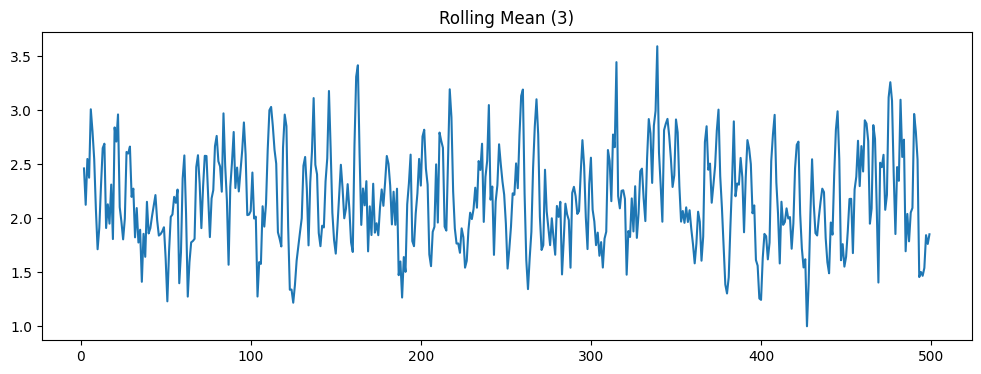

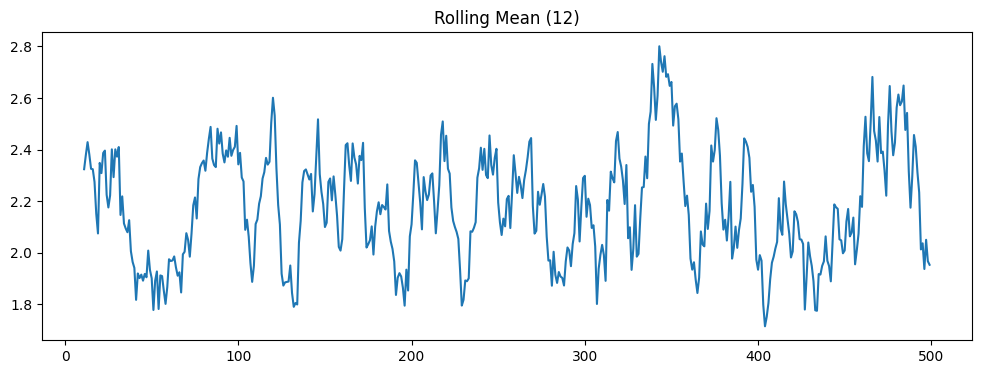

In [14]:
# ================================
# 5. Time series plots
# ================================
plt.figure(figsize=(12, 4))
df[target].plot(title=f"Raw Time Series – {target}")
plt.show()

plt.figure(figsize=(12, 4))
df[target].rolling(3).mean().plot(title="Rolling Mean (3)")
plt.show()

plt.figure(figsize=(12, 4))
df[target].rolling(12).mean().plot(title="Rolling Mean (12)")
plt.show()


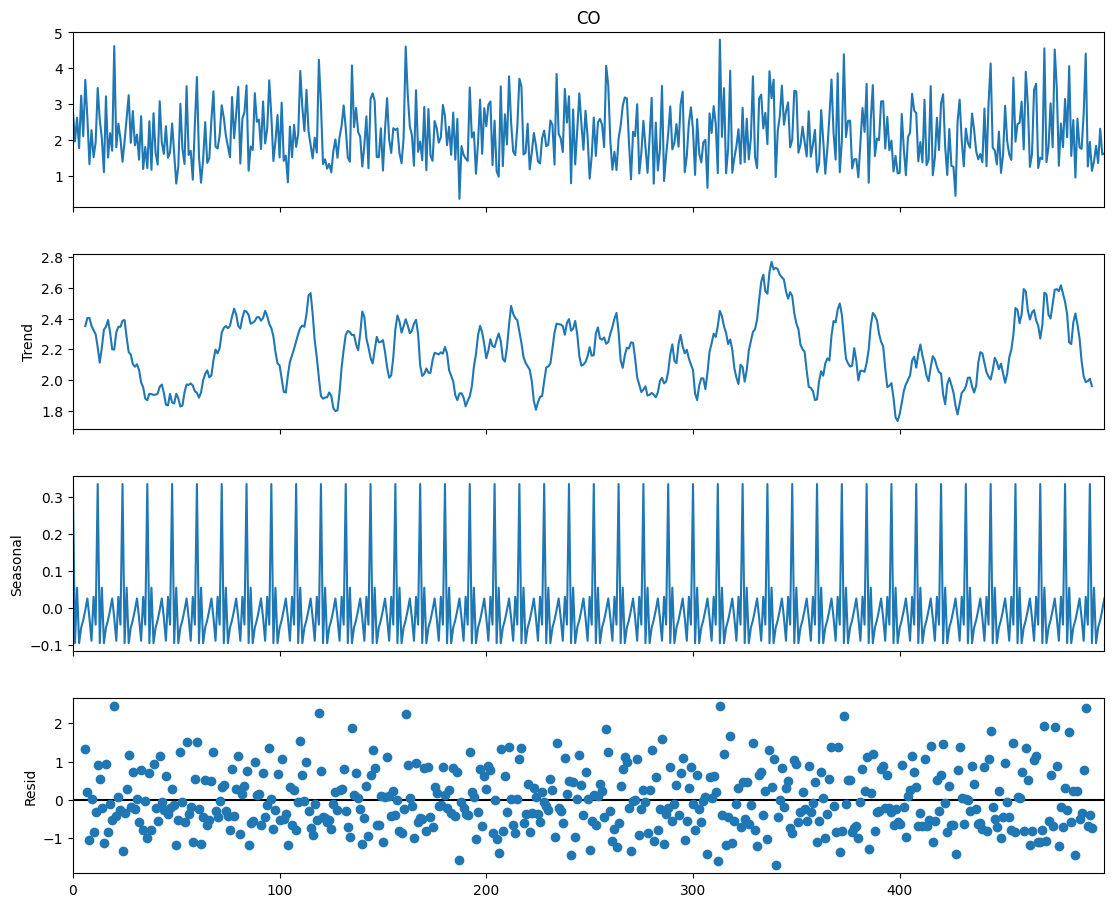

In [15]:
# ================================
# 6. Seasonal decomposition
# ================================
decomp = seasonal_decompose(df[target], model="additive", period=12)

fig = decomp.plot()
fig.set_size_inches(12, 10)
plt.show()


<Figure size 1000x400 with 0 Axes>

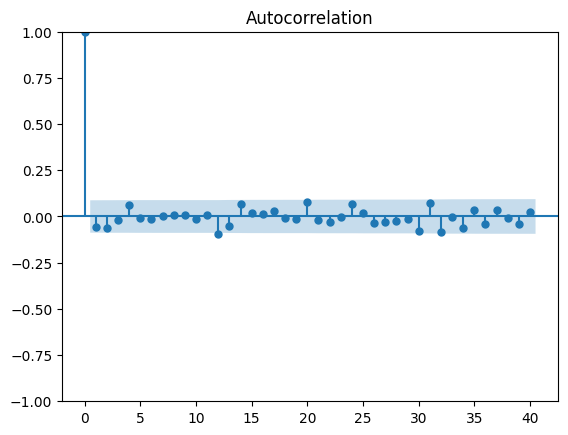

<Figure size 1000x400 with 0 Axes>

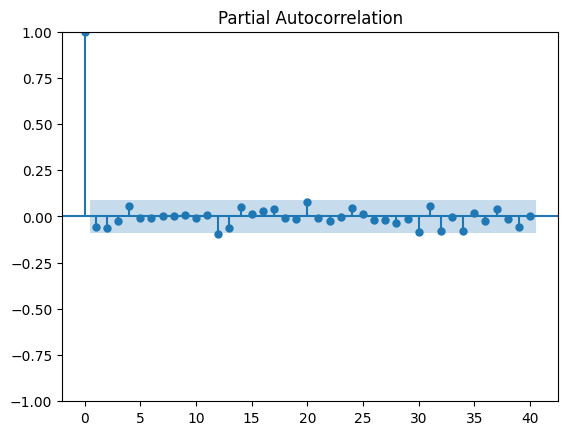

In [16]:
# ================================
# 7. ACF / PACF Plots
# ================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df[target].dropna(), lags=40)
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df[target].dropna(), lags=40, method="ywm")
plt.show()


In [17]:
# ================================
# 8. ADF stationarity test
# ================================
result = adfuller(df[target].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used lags:", result[2])
print("Observations:", result[3])


ADF Statistic: -17.21415514617672
p-value: 6.340730614877273e-30
Used lags: 1
Observations: 498


In [19]:
# ================================
# 9. Feature Engineering
# ================================
# Ensure datetime column exists and convert
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")   # IMPORTANT

def create_features(data):
    df_fe = data.copy()

    # Lag features
    df_fe["lag_1"] = df_fe[target].shift(1)
    df_fe["lag_2"] = df_fe[target].shift(2)
    df_fe["lag_12"] = df_fe[target].shift(12)

    # Rolling stats
    df_fe["roll_3"] = df_fe[target].rolling(3).mean()
    df_fe["roll_6"] = df_fe[target].rolling(6).mean()
    df_fe["roll_12"] = df_fe[target].rolling(12).mean()

    # Calendar features
    df_fe["month"] = df_fe.index.month
    df_fe["quarter"] = df_fe.index.quarter
    df_fe["month_sin"] = np.sin(2 * np.pi * df_fe.index.month / 12)
    df_fe["month_cos"] = np.cos(2 * np.pi * df_fe.index.month / 12)

    return df_fe

features = create_features(df)
features.head()


,PM2.5,PM10,NOx,NO2,SO2,VOCs,CO,CO2,CH4,Temperature,...,lag_1,lag_2,lag_12,roll_3,roll_6,roll_12,month,quarter,month_sin,month_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,39.967142,57.926035,116.192213,55.230299,4.531693,75.317261,2.789606,427.674347,1.706105,31.085120,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0.5,0.866025
2000-01-01 01:00:00,101.935672,150.774299,76.826826,79.051618,18.744780,145.083987,1.966569,529.739619,2.492663,33.711103,...,2.789606,NaN,NaN,NaN,NaN,NaN,1,1,0.5,0.866025
2000-01-01 02:00:00,70.996192,138.948796,158.731020,60.466604,14.892239,145.147338,2.626446,499.889443,2.431165,33.778698,...,1.966569,2.789606,NaN,2.460874,NaN,NaN,1,1,0.5,0.866025
2000-01-01 03:00:00,28.464728,63.643900,25.385343,15.333286,7.647429,130.022319,1.779360,388.283712,1.818563,31.565877,...,2.626446,1.966569,NaN,2.124125,NaN,NaN,1,1,0.5,0.866025
2000-01-01 04:00:00,78.265276,113.977926,105.644340,59.202337,17.696806,181.713667,3.240533,464.739197,2.597225,32.229835,...,1.779360,2.626446,NaN,2.548779,NaN,NaN,1,1,0.5,0.866025


In [23]:
# ================================
# 10. Save processed feature set
# ================================
# Save as CSV instead of parquet (local-friendly)
import pandas as pd

# Your CSV file
out_csv = "/content/processed_co2_dataset_with_datetime.csv"

# Load it
df = pd.read_csv(out_csv)

# Save as PKL
out_pkl = "/content/processed_co2_dataset_with_datetime.pkl"
df.to_pickle(out_pkl)
out_csv = "/content/processed_co2_dataset_with_datetime.csv"
out_pkl = "/content/processed_co2_dataset_with_datetime.pkl"

features.to_csv(out_csv)
features.to_pickle(out_pkl)

print("Saved:")
print("-", out_csv)
print("-", out_pkl)


Saved:
- /content/processed_co2_dataset_with_datetime.csv
- /content/processed_co2_dataset_with_datetime.pkl


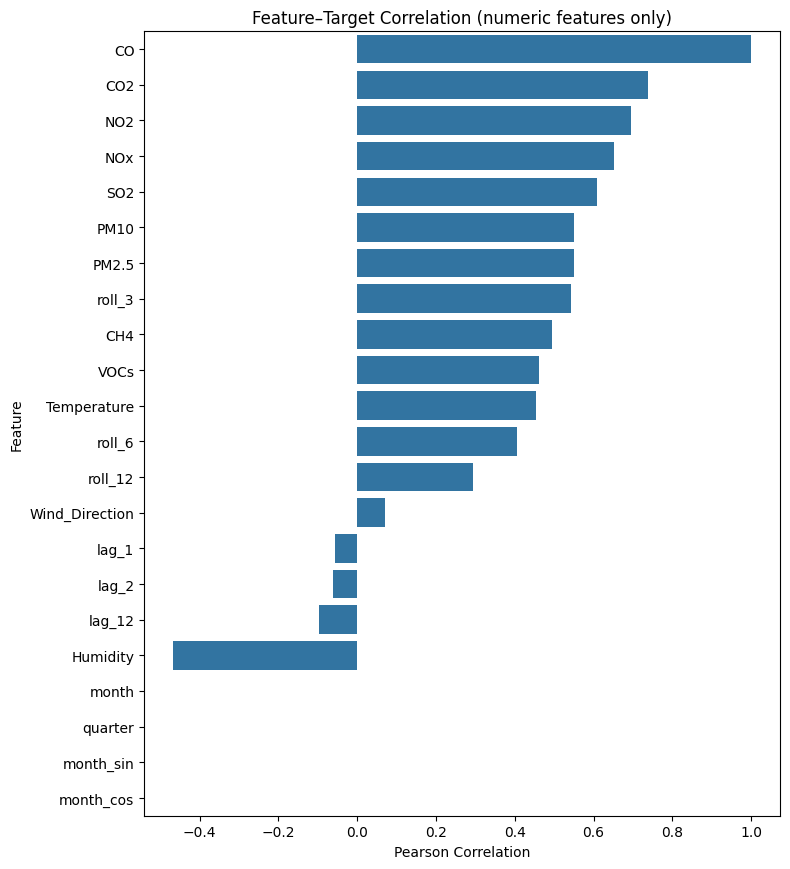

,CO
CO,1.000000
CO2,0.738116
NO2,0.694746
NOx,0.653013
SO2,0.607475
PM10,0.550709
PM2.5,0.549673
roll_3,0.542729
CH4,0.493549
VOCs,0.462175


In [25]:
# ================================
# 11. Feature Importance Proxy (SAFE VERSION)
# ================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Keep only numeric columns for correlation
numeric_features = features.select_dtypes(include=[np.number])

# 2. Ensure the target is numeric and exists in the numeric set
if target not in numeric_features.columns:
    raise KeyError(f"Target column '{target}' is not numeric or missing after filtering numeric columns.")

# 3. Compute correlations with target
corr = numeric_features.corr()[target].sort_values(ascending=False)

# 4. Plot top N correlations (prevents massive long plots)
top_n = 25  # you can change this
corr_to_plot = corr.head(top_n)

# 5. Plotting
plt.figure(figsize=(8, 0.4 * len(corr_to_plot)))
sns.barplot(x=corr_to_plot.values, y=corr_to_plot.index)
plt.title("Feature–Target Correlation (numeric features only)")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 6. Print correlations for inspection
corr_to_plot
